In [1]:
import pydicom as dicom
import numpy as np
import scipy 
import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


In [2]:
# Converter Class to convert the images in the CT coordinates to display coordinates
# It can be used to get the new coordinate of a point in the visualization fig
# there is an offset of the center + a flip in the y direction

class coordConverter:
    
    def __init__(self, xorigin, yorigin, pixsizex, pixsizey, dimx, dimy):
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.pixsizex = pixsizex
        self.pixsizey = pixsizey
        self.dimx = dimx
        self.dimy = dimy

    def convertCoord(self, x, y):
        newposx = int((x-self.xorigin)/self.pixsizex)
        newposy = int(self.dimy - (y-self.yorigin)/self.pixsizey)
        return (newposx, newposy)
    
    def converStructList(self, structList):
        newPointList = []
        for i in structList:
            newposx = int((i[0]-self.xorigin)/self.pixsizex)
            newposy = int(self.dimy - (i[1]-self.yorigin)/self.pixsizey)
            newPointList.append((newposx, newposy))
        return newPointList


In [3]:
def findCountourFile(path):
    
    # handles `/` missing
    if path[-1] != '/': path += '/'
    
    # get .dcm contour file
    fpaths = [path + f for f in os.listdir(path) if (('.dcm' in f)or('.DCM' in f))]
    n = 0
    contour_file = ''
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if 'ROIContourSequence' in dir(f):
            contour_file = fpath.split('/')[-1]
            n += 1
    if n > 1: warnings.warn("Many Contour Files, please specify which one you want !")
    if contour_file == '': print("No contour file in the selected directory")
    return contour_file

In [4]:
def findSPECTFile(path):
    
    # handles `/` missing
    if path[-1] != '/': path += '/'
    
    # get .dcm contour file
    fpaths = [path + f for f in os.listdir(path) if (('.dcm' in f)or('.DCM' in f))]
    n = 0
    file = ''
    for fpath in fpaths:
        img = dicom.read_file(fpath)
        if (img.Modality == 'NM'):
            file = fpath.split('/')[-1]
            n += 1
    if n > 1: warnings.warn("Many SPECT Files, please specify which one you want !")
    if file == '': print("No SPECT file in the selected directory")
    return file

In [26]:
def dispRoiNames(path, file):
    
    # checks if the path contains '/' and reads the file
    if path[-1] != '/': path += '/'
    d=dicom.dcmread(path + file)
    
    n = len(d.StructureSetROISequence)
    print('The file contains', n, 'structures:')

    for i in range(n):
        print('  ', i, ':', d.StructureSetROISequence[i].ROIName, '(', 
              len(struct.ROIContourSequence[i].ContourSequence), 'slices)')

In [27]:
# Finds the RTStruct file in the folder
m_path = 'imgs/'
contourFile = findCountourFile(m_path)
if contourFile != '': dispRoiNames(m_path, contourFile)
print('\n')


# Reads the RTStruct file and creates the list of points:
struct = dicom.dcmread(m_path + contourFile)


# Finds corresponding SPECT file (it must be the only SPECT file of it doesnt work)
SPECTfile = findSPECTFile(m_path)
print('The SPECT file is:', SPECTfile)


The file contains 2 structures:
   0 : External ( 183 slices)
   1 : ext+1.6cm ( 208 slices)


The SPECT file is: spect.DCM


In [7]:
# get the list of points for the structure on the slice of interest:
sliceOfInterest = 20
ROInb = 0
contour_dataset = struct.ROIContourSequence[ROInb].ContourSequence[sliceOfInterest]

print("lIST OF POINTS FROM THE STRUCTURE FILE \n")
print("Selected ROI:",struct.StructureSetROISequence[ROInb].ROIName)
print("Slice of interest:", sliceOfInterest, "\n")


# Reads the CT image corresponding to the slice of interest:
imgID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_path +'CT'+ imgID + '.dcm')

CTpixArray = CTimg.pixel_array
CTxSpacing, CTySpacing = float(CTimg.PixelSpacing[0]), float(CTimg.PixelSpacing[1])
CTxOrigin, CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 
CTsizeX, CTsizeY = CTimg.Rows, CTimg.Columns

print("CT Image dimension in pixels: (", CTsizeX, "x", CTsizeY, ")")
print("CT Pixel dimension in mm: (", CTxSpacing, "x", CTySpacing, ")")
print("CT Image Origin in mm: (", CTxOrigin, "x", CTyOrigin, ",", CTzOrigin, ")\n")


# Reads the SPECT image corresponding to the slice of interest:
SPECTimg = dicom.read_file(m_path + SPECTfile)

SPECTpixArray = SPECTimg.pixel_array
SPECTxSpacing, SPECTySpacing = float(SPECTimg.PixelSpacing[0]), float(SPECTimg.PixelSpacing[1])
SPECTzSpacing = SPECTimg[0x0018,0x0050].value
[SPECTxOrigin, SPECTyOrigin, SPECTzOrigin] = SPECTimg[0x0054,0x0022][0][0x0020,0X0032] 
SPECTsizeX, SPECTsizeY = SPECTimg.Rows, SPECTimg.Columns

print("SPECT Image dimension in pixels: (", SPECTsizeX, "x", SPECTsizeY, ")")
print("SPECT Pixel dimension in mm: (", SPECTxSpacing, "x", SPECTySpacing, "x", SPECTzSpacing, ")")
print("SPECT Image Origin in mm: (", SPECTxOrigin, ",", SPECTyOrigin, ",", SPECTzOrigin, ")\n")


# Reads the list of points of the structure file on this slice of interest:
c1=contour_dataset.ContourData
points=int(contour_dataset.NumberOfContourPoints) 
print("Nb of points in the structure:", points)

pointList = []
for i in range (0,points):
    x1 = c1[(i*3)]
    y1 = c1[(i*3)+1]
    pointList.append((x1, y1))


lIST OF POINTS FROM THE STRUCTURE FILE 

Selected ROI: External
Slice of interest: 20 

CT Image dimension in pixels: ( 512 x 512 )
CT Pixel dimension in mm: ( 0.976562 x 0.976562 )
CT Image Origin in mm: ( -250.000 x -250.000 , -73.750 )

SPECT Image dimension in pixels: ( 128 x 128 )
SPECT Pixel dimension in mm: ( 4.418156 x 4.418156 x 4.41816 )
SPECT Image Origin in mm: ( -283.252906 , -277.852906 , 280.552906 )

Nb of points in the structure: 353


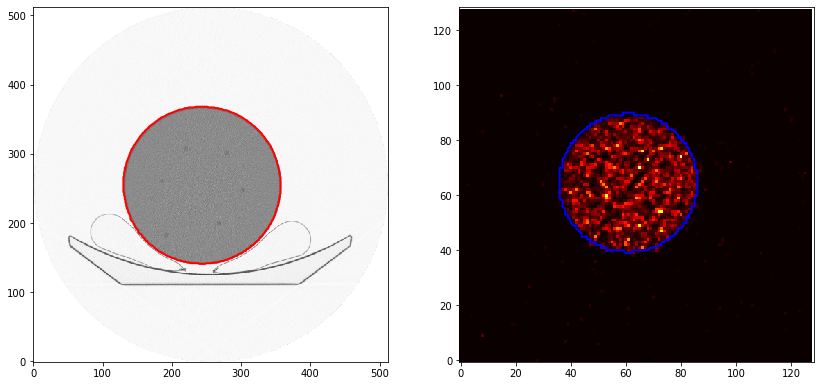

In [8]:
# 2D DISPLAY OF THE CONTOUR
# For display purposes, we need to switch from the image axes to the display axes


# Display and calculation Grid definition: (for CT and SPECT)
CTgrid_min = (0,0)
CTgrid_size = (CTsizeX, CTsizeY)
CTstep = (1,1)
CTvisFactor = 8
CTgrid_max = ((CTgrid_min[0]+CTgrid_size[0]*CTstep[0]), 
              (CTgrid_min[1]+CTgrid_size[1]*CTstep[1]))

SPECTgrid_min = (0,0)
SPECTgrid_size = (SPECTsizeX, SPECTsizeY)
SPECTstep = (1,1)
SPECTvisFactor = 8
SPECTgrid_max = ((SPECTgrid_min[0]+SPECTgrid_size[0]*SPECTstep[0]), 
                 (SPECTgrid_min[1]+SPECTgrid_size[1]*SPECTstep[1]))

CorrespondingSPECTSlice = int((SPECTzOrigin-CTzOrigin) / SPECTzSpacing)


# Matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.set_xlim(CTgrid_min[0]-0.5*CTstep[0], CTgrid_max[0]+0.5*CTstep[0])
ax1.set_ylim(CTgrid_min[1]-0.5*CTstep[1], CTgrid_max[1]+0.5*CTstep[1])

ax2.set_xlim(SPECTgrid_min[0]-0.5*SPECTstep[0], SPECTgrid_max[0]+0.5*SPECTstep[0])
ax2.set_ylim(SPECTgrid_min[1]-0.5*SPECTstep[1], SPECTgrid_max[1]+0.5*SPECTstep[1])


# Displays the background images
ax1.imshow(np.flip(CTpixArray, 0), cmap="Greys", interpolation="nearest", 
           vmin = -100, vmax = 2000)

ax2.imshow(np.flip(SPECTpixArray[CorrespondingSPECTSlice,:,:], 0), cmap="hot", interpolation="nearest", 
           vmin = 0, vmax = 300)


# Creation of the contour:
cc1 = coordConverter(CTxOrigin, CTyOrigin, CTxSpacing, CTySpacing, CTsizeX, CTsizeY)
CTdispPointList = cc1.converStructList(pointList)
CTpath_contour = matplotlib.path.Path(CTdispPointList)


# Creation of the contour:
cc2 = coordConverter(SPECTxOrigin, SPECTyOrigin, SPECTxSpacing, SPECTySpacing, SPECTsizeX, SPECTsizeY)
SPECTdispPointList = cc2.converStructList(pointList)
SPECTpath_contour = matplotlib.path.Path(SPECTdispPointList)


# Plots the contour
polygoneCT = plt.Polygon(CTdispPointList, fill=False, color = "red", linewidth=2)
ax1.add_patch(polygoneCT)

polygoneSPECT = plt.Polygon(SPECTdispPointList, fill=False, color = "blue", linewidth=2)
ax2.add_patch(polygoneSPECT)



rESULTS:
 -> Selected slice 80
 -> ROI volume: 166276.3802181449 mm3
 -> Total nb of counts: 82913
 -> Mean nb of counts: 43.00466804979253


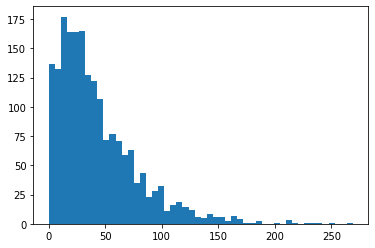

In [31]:
# NB OF COUNTS IN STRUCTURE CALCULATION (2D version):

volPixel = SPECTxSpacing * SPECTySpacing * SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []
for i in range(SPECTsizeX):
    for j in range(SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += SPECTpixArray[CorrespondingSPECTSlice,j,i]
            pixValues.append(SPECTpixArray[CorrespondingSPECTSlice,j,i])
            nbPix += 1

print('rESULTS:')
print(' -> Selected slice', CorrespondingSPECTSlice)
print(' -> ROI volume:', volROI, 'mm3')            
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> Mean nb of counts:', nbCountsInROI/nbPix)

plt.hist(pixValues, 50)
plt.show()

In [37]:
# NB OF COUNTS IN STRUCTURE CALCULATION (3D version):


# Variables initialization:
volPixel = SPECTxSpacing * SPECTySpacing * SPECTzSpacing
volROI = 0
nbCountsInROI = 0
nbPix = 0
pixValues = []


# Reads the list of points of the structure file on this slice of interest:
print('rEADING THE STRUCTURES FILE:')
print(' -> nb of structures:', len(struct.ROIContourSequence))
for i in range(len(struct.ROIContourSequence)):
    print(' -> nb of slices for struct no', i, ':', len(struct.ROIContourSequence[i].ContourSequence))
print('\n\n')


# compute statistics in the selected ROI (ROInb):
contour_dataset = struct.ROIContourSequence[ROInb].ContourSequence[0]
imgID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_path +'CT'+ imgID + '.dcm')
CTxOrigin, CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 

SPECTslice = int((SPECTzOrigin-CTzOrigin) / SPECTzSpacing)
for i in range(SPECTsizeX):
    for j in range(SPECTsizeY):
        if SPECTpath_contour.contains_point((i,j)):
            volROI += volPixel
            nbCountsInROI += SPECTpixArray[SPECTslice,j,i]
            pixValues.append(SPECTpixArray[SPECTslice,j,i])
            nbPix += 1


for s in range(len(struct.ROIContourSequence[ROInb].ContourSequence)):
    imgID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    CTimg = dicom.read_file(m_path +'CT'+ imgID + '.dcm')
    CTxOrigin, CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 
    newslice = int((SPECTzOrigin-CTzOrigin) / SPECTzSpacing)
    print(newslice)
    if newslice != SPECTslice:
        SPECTslice = newslice
        for i in range(SPECTsizeX):
            for j in range(SPECTsizeY):
                if SPECTpath_contour.contains_point((i,j)):
                    volROI += volPixel
                    nbCountsInROI += SPECTpixArray[SPECTslice,j,i]
                    pixValues.append(SPECTpixArray[SPECTslice,j,i])
                    nbPix += 1
                    
print('rESULTS:')
print(' -> Selected ROI:', ROInb)
print(' -> ROI volume:', volROI, 'mm3')            
print(' -> Total nb of counts:', nbCountsInROI)
print(' -> Mean nb of counts in a pixel:', nbCountsInROI/nbPix)

plt.hist(pixValues, 50)
plt.show()

rEADING THE STRUCTURES FILE:
 -> nb of structures: 2
 -> nb of slices for struct no 0 : 183
 -> nb of slices for struct no 1 : 208



85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
85
rESULTS:
 -> Selected ROI: 0
 -> ROI volume: 0 mm3
 -> Total nb of counts: 0


ZeroDivisionError: division by zero

In [ ]:
N=0
pc=np.zeros((128,128,128))
for k in range (0,128):
    for i in range(0,128):
        for j in range(0,128):
             if mm[k,i,j]>0 :
                  pc[k,i,j]=p[k,i,j]
                  N=N+1
                    
v_f=(N*v_pixel) *10**(-3)                
print('le volume est de=',v_f  )                 
cp=np.sum(pc)
hour=int(img.AcquisitionTime[0:2])-14
min=int(img.AcquisitionTime[2:4])-59
t_s1=(23+hour)*60+min+10        #temps de comencent d'acqusition detecteur1  (min)
t_aq=int(img.RotationInformationSequence[0].ActualFrameDuration)*0.5/10**3         #duré d'acqusition (min)
t_p=792     #periode physique de 123-I (min)
#----------------------------------------------------------------------------------
A_inj_s1 =0.001093*16+(v_f+(-16))*0.000298   # l'activité de la suringue pliene (mCi)
t_s11=1       #temps de mesure  l'activité de la suringue pliene (min)
A_ss1=0   # l'activité de la suringue vide (mCi)
t_ss1=0       #temps de mesure  l'activité de la suringue vide (min)

A_ss1=(A_ss1 * exp((log(2)*t_ss1)/t_p))
A_inj_s1=(A_inj_s1 * exp((log(2)*t_s11)/t_p))
#correction de l'activité exact injecté  .
A_s1=A_inj_s1-A_ss1
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
A_inj_s2 =0.001093*8 +(v_f+(-8))*0.000298   # l'activité de la suringue pliene (mCi)
t_s2=1       #temps de mesure  l'activité de la suringue pliene (min)
A_ss2=0   # l'activité de la suringue vide (mCi)
t_ss2=0       #temps de mesure  l'activité de la suringue vide (min)

A_ss2=(A_ss2 * exp((log(2)*t_ss2)/t_p))
A_inj_s2=(A_inj_s2 * exp((log(2)*t_s2)/t_p))
#correction de l'activité exact injecté  .
A_s2=A_inj_s2-A_ss2
#----------------------------------------------------------------------------------
A_inj_fond =2.04   # l'activité de la suringue pliene (mCi)
t_fond=1      #temps de mesure  l'activité de la suringue pliene (min)
A_sfond=0  # l'activité de la suringue vide (mCi)
t_sfond=4      #temps de mesure  l'activité de la suringue vide (min)

A_sfond=(A_sfond * exp((log(2)*t_sfond)/t_p))
A_inj_fond=(A_inj_fond * exp((log(2)*t_fond)/t_p))
#correction de l'activité exact injecté  .
A_fond=A_inj_fond-A_sfond
#----------------------------------------------------------------------------------


#----------------------------------------------------------------------------------






#A_total=A_pd+A_lf+A_lc+A_foie+A_fond+A_pg
A_total=A_fond
# l'activité au moment de commencement d'acquisition  .

# l'activité au moment de commencement d'acquisition  .
A_01=A_total * exp((-log(2)*t_s1)/t_p)


# l'activité moyenne entre le debut et la fin d'acquisition mCi .


# nombre de coups par seconde    
cps=cp/(t_aq*2*60)
# l'activité moyenne entre le debut et la fin d'acquisition (MBq)  .
A_m1=(A_01 *37*(t_p/log(2))* (1-exp(-log(2)*t_aq/t_p)))/t_aq

A_mesuré=cps/62.5
print('activité réelle =',A_m1)
print('activité mesuré',A_mesuré)
v=abs(A_mesuré-A_m1)*100/A_m1
print('variation relative',v,'%')